# Void Tracking
Demonstration of how to use the void tracking utilities

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from rtdefects.analysis import track_voids, compute_drift, compile_void_tracks
import pandas as pd
import numpy as np

## Load in the defect information
The `rtdefects` command-line application generates a JSON file with the positions and sizes of each void detected in each frame.

Our first step is to load that JSON into memory

In [2]:
void_data = pd.read_json('files/video34-Ni-600C-then-650C_defects.json', lines=True).sort_values("image-path", ignore_index=True)
print(f'Loaded defects from {len(void_data)} frames')

Loaded defects from 1477 frames


## Show that we've detected void growth
Without tracking individual voids, we can see that they are growing in size and number

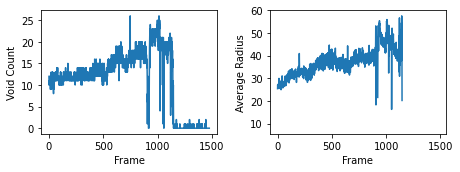

In [3]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(6.5, 2.5))

axs[0].plot(void_data.index, void_data['void_count'])
axs[0].set_ylabel('Void Count')

axs[1].plot(void_data.index, void_data['radii_average'])
axs[1].set_ylabel('Average Radius')

for ax in axs:
    ax.set_xlabel('Frame')
    
fig.tight_layout()

We can see that we are detecting at least a dozen void per frame. Both the number and size increase with time.

There are many frames at the end where we don't detect any defects. Let's eliminate thsoe from the analysis.

In [4]:
void_data.query('void_count > 0', inplace=True, )
print(f'Reduced to {len(void_data)} frames with at least 1 void.')

Reduced to 1166 frames with at least 1 void.


## Do an initial pass of defect detection
We are going to get the positions of the slow-moving voids to detect the drift between frames

In [5]:
%%time
initial_tracks = track_voids(void_data['positions'].tolist(), threshold=10)
print(f'Found {len(initial_tracks)} unique voids from a total of {np.sum(initial_tracks > 0)} detected')

Found 3182 unique voids from a total of 15631 detected
CPU times: user 301 ms, sys: 9.96 ms, total: 311 ms
Wall time: 314 ms


Let's plot the tracks of a few

In [6]:
void_tracks = compile_void_tracks(void_data['positions'].tolist(), initial_tracks)
void_tracks

,start_frame,end_frame,total_frames,positions,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate
0,0,38,39,"[[6.161048689138576, 112.85393258426966], [6.2...","[0.0, 1.5022461296234388, 3.0698828260430635, ...",40.733134,1.044439,"[0.0, 1.5022461296234388, 3.0720634513540834, ...",61.287659,1.571478
1,0,0,1,"[[27.875838926174495, 320.96644295302013]]",NaN,NaN,NaN,NaN,NaN,NaN
2,0,90,91,"[[89.68503937007874, 127.82114735658043], [90....","[0.0, 1.1170801527332135, 2.106294050835948, 4...",90.385912,0.993252,"[0.0, 1.1170801527332135, 2.1294832508939914, ...",160.564813,1.764448
3,0,12,13,"[[121.0231884057971, 240.13333333333333], [121...","[0.0, 1.1752327774052405, 2.5863356750798827, ...",12.890716,0.991594,"[0.0, 1.1752327774052405, 2.6563308287154017, ...",18.844002,1.449539
4,0,12,13,"[[247.7584803256445, 398.57937584803256], [247...","[0.0, 1.8969949257770593, 2.0976253821983657, ...",12.804450,0.984958,"[0.0, 1.8969949257770593, 2.1964728249287178, ...",17.621374,1.355490
...,...,...,...,...,...,...,...,...,...,...
3177,1162,1162,1,"[[664.115, 177.52]]",NaN,NaN,NaN,NaN,NaN,NaN
3178,1163,1163,1,"[[111.34375, 22.010416666666668]]",NaN,NaN,NaN,NaN,NaN,NaN
3179,1164,1164,1,"[[627.9826589595376, 578.4190751445087]]",NaN,NaN,NaN,NaN,NaN,NaN
3180,1165,1165,1,"[[697.3555555555556, 110.46666666666667]]",NaN,NaN,NaN,NaN,NaN,NaN


(0.0, 1024.0)

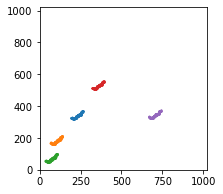

In [7]:
fig, ax = plt.subplots(figsize=(3, 3))


longest_tracks = void_tracks.sort_values('total_frames').tail(5)
for pos in longest_tracks['positions']:
    ax.plot(pos[:, 0], pos[:, 1], ':o', ms=1)

ax.set_xlim(0, 1024)
ax.set_ylim(0, 1024)

We can see a systematic trend with all of the voids "moving" the same direction, which we can attribute to image drift.

## Removing Drift
We detect drift from the median movement of all voids over each frame.

In [8]:
drift = compute_drift(initial_tracks, void_data['positions'].tolist())

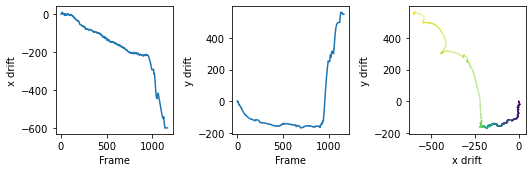

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5))

for ax, i, l in zip(axs, range(2), ['x', 'y']):
    ax.plot(drift[:, i])
    ax.set_xlabel('Frame')
    ax.set_ylabel(l + ' drift')

axs[2].scatter(drift[:, 0], drift[:, 1], c=np.arange(drift.shape[0]), s=0.1)
axs[2].set_xlabel('x drift')
axs[2].set_ylabel('y drift')

fig.tight_layout()

We can see there are two distinct phases of drift. We gradually move to the lower left and then to the upper left.

Given these drifts, let's re-evaluate the positions of each void

In [10]:
void_data['actual_positions'] = [np.subtract(p, d) for p, d in zip(void_data['positions'], drift)]

In [11]:
void_tracks = compile_void_tracks(void_data['actual_positions'].tolist(), initial_tracks)

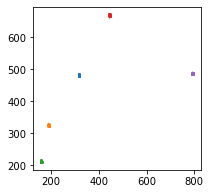

In [12]:
fig, ax = plt.subplots(figsize=(3, 3))


longest_tracks = void_tracks.sort_values('total_frames').tail(5)
for pos in longest_tracks['positions']:
    ax.plot(pos[:, 0], pos[:, 1], ':o', ms=1)

Note they are all mostly static

## Remove drift and then re-detect voids
Now that we know which movements are due to the microscope drift, we can be more confident in labeling voids.

In [13]:
%%time
tracks = track_voids(void_data['actual_positions'].tolist(), threshold=10)
print(f'Found {len(tracks)} unique voids from a total of {np.sum(tracks > 0)} detected')

Found 2526 unique voids from a total of 15631 detected
CPU times: user 262 ms, sys: 41.7 ms, total: 304 ms
Wall time: 245 ms


Note how we fewer unique voids this time! Things that initially "moved" too far to detect because of the camera drift are now associated together.

In [14]:
void_tracks = compile_void_tracks(void_data['actual_positions'].tolist(), tracks, void_data['radii'].tolist())
void_tracks

,start_frame,end_frame,total_frames,positions,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
0,0,38,39,"[[6.161048689138576, 112.85393258426966], [6.0...","[0.0, 0.16575776316605317, 0.4066787096789729,...",4.544139,0.116516,"[0.0, 0.16575776316605317, 0.4552567819352688,...",33.833452,0.867524,"[18.437867513470433, 19.08262324195121, 19.281...",26.123866,14.668929,-0.095582
1,0,0,1,"[[27.875838926174495, 320.96644295302013]]",NaN,NaN,NaN,NaN,NaN,NaN,[19.47884453275087],19.478845,19.478845,NaN
2,0,90,91,"[[89.68503937007874, 127.82114735658043], [89....","[0.0, 0.3471476922544422, 0.5807706435567195, ...",2.059030,0.022627,"[0.0, 0.3471476922544422, 0.6488045421373106, ...",55.972481,0.615082,"[33.64386950500135, 33.33973788969849, 34.0763...",38.629480,33.090573,0.046965
3,0,22,23,"[[121.0231884057971, 240.13333333333333], [121...","[0.0, 0.5659027784767252, 0.420591103996161, 0...",3.431565,0.149198,"[0.0, 0.5659027784767252, 0.774020499556609, 1...",20.067441,0.872497,"[20.958712816717327, 21.290215544369623, 21.90...",24.721549,20.652730,0.052510
4,0,90,91,"[[247.7584803256445, 398.57937584803256], [247...","[0.0, 0.5050488187505003, 0.5998002591927982, ...",1.515365,0.016652,"[0.0, 0.5050488187505003, 1.6093816456734817, ...",43.498973,0.478011,"[30.632948674096244, 29.70446102021492, 29.811...",36.072854,29.402885,0.055697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2521,1162,1162,1,"[[1262.5721513634633, -372.1526003232053]]",NaN,NaN,NaN,NaN,NaN,NaN,[15.957691216057308],15.957691,15.957691,NaN
2522,1163,1163,1,"[[709.8009013634633, -527.6621836565387]]",NaN,NaN,NaN,NaN,NaN,NaN,[11.055812783082736],11.055813,11.055813,NaN
2523,1164,1164,1,"[[1226.439810323001, 28.746474821303423]]",NaN,NaN,NaN,NaN,NaN,NaN,[20.98906578384008],20.989066,20.989066,NaN
2524,1165,1165,1,"[[1295.8127069190189, -439.2059336565386]]",NaN,NaN,NaN,NaN,NaN,NaN,[13.110581167104948],13.110581,13.110581,NaN


## Perform some analyzes
Show some key points we learn about the voids

(10.0, 60.0)

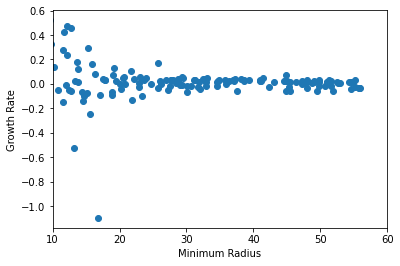

In [15]:
fig, ax = plt.subplots()
long_lived = void_tracks.query('total_frames > 15')

ax.scatter(long_lived['min_radius'], long_lived['growth_rate'])
ax.set_xlabel('Minimum Radius')
ax.set_ylabel('Growth Rate')

ax.set_xlim(10, 60)
#ax.set_ylim(-1, 1)

We have a partition between small voids that grow and disappear

Text(0, 0.5, 'Movement Rate')

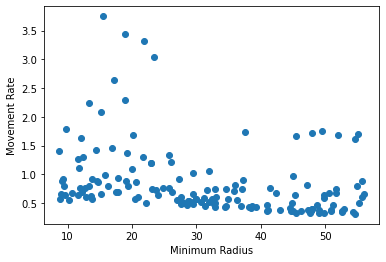

In [16]:
fig, ax = plt.subplots()

long_lived = void_tracks.query('total_frames > 15')

ax.scatter(long_lived['min_radius'], long_lived['movement_rate'])
ax.set_xlabel('Minimum Radius')
ax.set_ylabel('Movement Rate')

Small voids generally move farther than larger ones

In [17]:
void_tracks.to_csv('void_tracks.csv', index=False)